In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.distributions.normal import Normal
import numpy as np

In [2]:
batch_size = 64

# MNIST Dataset 
mnist = dsets.MNIST(root='./data', 
                      train=True, 
                      transform=transforms.ToTensor(),  
                      download=True)

# Data Loader (Input Pipeline)
data_loader = torch.utils.data.DataLoader(dataset=mnist, 
                                          batch_size=batch_size, 
                                          shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21345371.78it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 329246.36it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5144760.04it/s]                           
8192it [00:00, 130841.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ################# uses gpu if available
print(device)

cuda


In [0]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [0]:
class aae_encoder(nn.Module):
    def __init__(self, X_dim):
        super(aae_encoder, self).__init__()
        self.input_size = X_dim
        
        
        self.layer1 = nn.Linear(X_dim, 400)
        self.layer2 = nn.Linear(400, 100)
        
        ######## mean and variance for gauss distribution
        self.mean = nn.Linear(100, 2)
        self.variance = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.dropout(self.layer1(x), p=0.2)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(self.layer2(x), p=0.2)
        x = F.leaky_relu(x, 0.2)
        
        ####### gaussion distribution
        mean_layer = self.mean(x)
        variance_layer = self.variance(x)
        gauss_layer = Normal(torch.tensor(mean_layer), torch.tensor(variance_layer))
        xgauss = gauss_layer.sample()+mean_layer
        
        return xgauss
    
class aae_decoder(nn.Module):
    def __init__(self, X_dim):
        super(aae_decoder, self).__init__()
        self.output_size = X_dim
        
        self.layer1 = nn.Linear(12, 100)
        self.layer2 = nn.Linear(100, 400)
        self.layer3 = nn.Linear(400, X_dim)
    
    def forward(self, x):
        x = F.dropout(self.layer1(x), p=0.2)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(self.layer2(x), p=0.2)
        x = F.leaky_relu(x, 0.2)
        
        x = self.layer3(x)
        
        return torch.sigmoid(x)
    
class aae_discriminator(nn.Module):
    def __init__(self):
        super(aae_discriminator, self).__init__()
        
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.dropout(self.layer1(x), p=0.2)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(self.layer2(x), p=0.2)
        x = F.leaky_relu(x, 0.2)
        
        x = self.layer3(x)
        
        return torch.sigmoid(x)
        

In [0]:
class AAE(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        
    def forward(self, x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        discriminator_output = self.discriminator(encoder_output)
        
        return decoder_output, discriminator_output

In [0]:
def get_categorical(labels, n_classes=10):
    cat = np.array(labels.data.tolist())
    cat = np.eye(n_classes)[cat].astype('float32')
    cat = torch.from_numpy(cat)
    return Variable(cat)

In [0]:
EPS = 1e-15
N = 512
latent_dim = 2
encoder = aae_encoder(784)
decoder = aae_decoder(784)
discriminator = aae_discriminator()

aae = AAE(encoder, decoder, discriminator)

In [0]:
# Set learning rates
gen_lr = 0.00005
reg_lr = 0.00005

#encode/decode optimizers
encoder_optim = torch.optim.Adam(encoder.parameters(), lr=gen_lr)
decoder_optim = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
#regularizing optimizers
encoder_gen_optim = torch.optim.Adam(decoder.parameters(), lr=reg_lr)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=reg_lr)

data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 50000

In [0]:
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    aae.cuda()

In [32]:
# Start training

reconstruction_loss = []
discriminator_loss = []
generator_loss = []
gen_learning_rate = []
reg_learning_rate = []

# z_real_gauss = Variable(torch.randn(batch_size, latent_dim) * 5.)

for step in range(total_step):
    
    if (step+1)%10000 and step<30000 == 0:
        gen_lr /= 2
        reg_lr /= 2

    gen_learning_rate.append(gen_lr)
    reg_learning_rate.append(reg_lr)
    
    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)
    try:
      # Fetch the images and labels and convert them to variables
      images, labels = next(data_iter)
      images, labels = to_var(images.view(batch_size, -1)), to_var(labels)

      #reconstruction loss
      decoder.zero_grad()
      encoder.zero_grad()
      discriminator.zero_grad()


  #       X_sample, pred = aae(images)

      z_gauss = encoder(images)
      z_cat = get_categorical(labels, n_classes=10)
      if torch.cuda.is_available():
          z_cat = z_cat.cuda()

      z_sample = torch.cat((z_cat, z_gauss), 1)

      X_sample = decoder(z_sample)

      recon_loss = F.binary_cross_entropy(X_sample+EPS,images+EPS)

      recon_loss.backward()
      decoder_optim.step()
      encoder_optim.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
      encoder.eval()
  #     z_real_gauss = Variable(torch.randn(images.size()[0], latent_dim) * 5.).cuda()
  #     z_real_gauss = Variable(torch.randn(batch_size, latent_dim) * 5., )

      z_gauss = encoder(images)
      pred = discriminator(z_gauss)
      z_real_gauss = torch.randn(images.size()[0], latent_dim, device = device) * 5.
      Disc_real_gauss = discriminator(z_real_gauss)

      Disc_loss = -torch.mean(torch.log(Disc_real_gauss + EPS) + torch.log(1 - pred + EPS))

      Disc_loss.backward(retain_graph=True)
      discriminator_optim.step()

    # Generator
      encoder.train()
      z_fake_gauss = encoder(images)
      Disc_fake_gauss = discriminator(z_fake_gauss)

      Gen_loss = -torch.mean(torch.log(Disc_fake_gauss + EPS))

      Gen_loss.backward()
      encoder_gen_optim.step()   


      if (step+1) % 10 == 0:
        print('For Step:', step+1 ,'recon_loss:', recon_loss.item(),
        '\tdiscriminator_loss:', Disc_loss.item(),
        '\tgenerator_loss:', Gen_loss.item())
        reconstruction_loss.append(recon_loss.item())
        discriminator_loss.append(Disc_loss.item())
        generator_loss.append(Gen_loss.item())
    except:
      pass


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For Step: 10 recon_loss: 0.6854108572006226 	discriminator_loss: 1.4154573678970337 	generator_loss: 0.7838004231452942
For Step: 20 recon_loss: 0.6743863821029663 	discriminator_loss: 1.4732321500778198 	generator_loss: 0.7836883068084717
For Step: 30 recon_loss: 0.6603026390075684 	discriminator_loss: 1.3835822343826294 	generator_loss: 0.7872207760810852
For Step: 40 recon_loss: 0.634096086025238 	discriminator_loss: 1.3958449363708496 	generator_loss: 0.7769699692726135
For Step: 50 recon_loss: 0.5906427502632141 	discriminator_loss: 1.3698089122772217 	generator_loss: 0.741889238357544
For Step: 60 recon_loss: 0.523400604724884 	discriminator_loss: 1.4321684837341309 	generator_loss: 0.6854424476623535
For Step: 70 recon_loss: 0.42255887389183044 	discriminator_loss: 1.5095325708389282 	generator_loss: 0.6356086730957031
For Step: 80 recon_loss: 0.36369454860687256 	discriminator_loss: 1.5137591361999512 	generator_loss: 0.6097424030303955
For Step: 90 recon_loss: 0.32127875089645

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

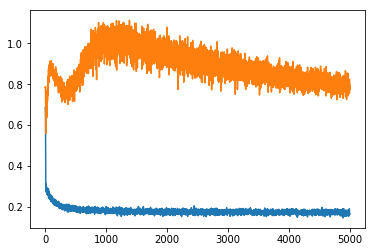

In [34]:
plt.plot(reconstruction_loss)
#plt.plot(discriminator_loss)
plt.plot(generator_loss)

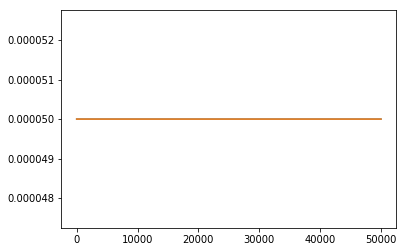

In [35]:
plt.plot(gen_learning_rate)
plt.plot(reg_learning_rate)

In [0]:
def save_images():
  noise = torch.randn(100, latent_dim+10, device = device)
  generated = decoder(noise).reshape(-1, 28, 28)
  generated = 0.5 * generated + 0.5
  gen = generated.cpu()
  return gen.detach().numpy()

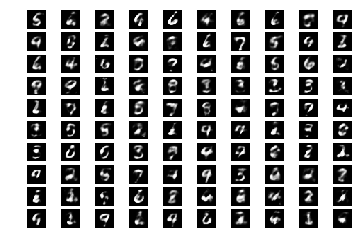

In [37]:
gen_img = save_images()

fig, axs = plt.subplots(10, 10)
count = 0
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(gen_img[count, :,:,], cmap='gray')
        axs[i,j].axis('off')
        count += 1